In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import copy

import numpy as np
import gym
import gym_keygrid
import pandas as pd

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils import policy_display, states_display, qtable_display, plot_state_freq, plot_scores

### Environment and Optimal Value Function

In [3]:
env = gym.make('keygrid-v0', grid_length=10)

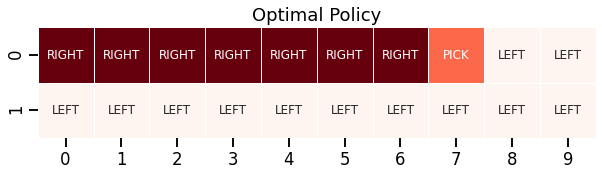

In [4]:
policy_display(env, env.opt_policy, title="Optimal Policy")

### TD Learning using optimal policy

In [5]:
from td_learning import td_learning

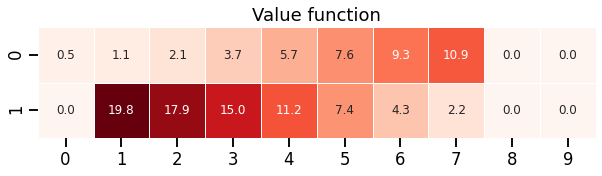

In [6]:
v_array = td_learning(env.opt_policy, env, display=False)

_ = states_display(v_array, title="Value function")

### Q Learning 

In [7]:
from td_learning import q_learning

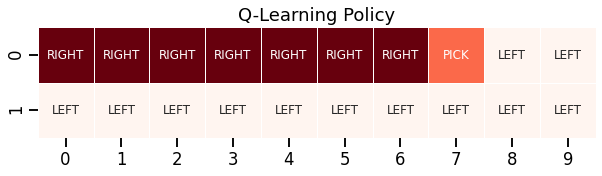

In [8]:
q_table = q_learning(env, display=False, num_episodes=50000)
q_policy = {x: env.actions[np.argmax(q_table[x])] for x in env.states}
_ = policy_display(env, q_policy, "Q-Learning Policy")

### Genetic Algorithm

In [9]:
from GA import train, get_best_agent

In [10]:
best_agents = train(env)


****************************************************************************************************
TRAINING START

Generation: 1 Score: 0
Generation: 2 Score: 0
Generation: 3 Score: 0
Generation: 4 Score: 0
Generation: 5 Score: 10
Generation: 6 Score: 10
Generation: 7 Score: 10
Generation: 8 Score: 10
Generation: 9 Score: 10
Generation: 10 Score: 10
Generation: 11 Score: 10
Generation: 12 Score: 10
Generation: 13 Score: 10
Generation: 14 Score: 10
Generation: 15 Score: 10
Generation: 16 Score: 10
Generation: 17 Score: 10
Generation: 18 Score: 10
Generation: 19 Score: 10
Generation: 20 Score: 10
Generation: 21 Score: 10
Generation: 22 Score: 10
Generation: 23 Score: 10
Generation: 24 Score: 10
Generation: 25 Score: 10
Generation: 26 Score: 10
Generation: 27 Score: 10
Generation: 28 Score: 10
Generation: 29 Score: 10
Generation: 30 Score: 10
Generation: 31 Score: 10
Generation: 32 Score: 10
Generation: 33 Score: 10
Generation: 34 Score: 10
Generation: 35 Score: 10
Generation: 36 Score

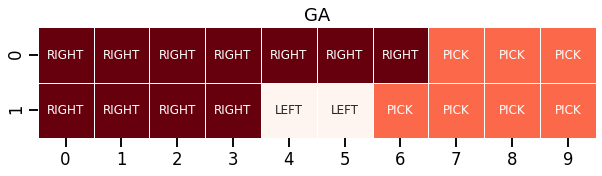

In [11]:
policy  = {x: get_best_agent(best_agents).get_action(x) for x in env.states}
policy_display(env, policy, "GA")

### ES Algorithm

In [12]:
from ES import train

In [13]:
agent = train(env)


****************************************************************************************************
TRAINING START

(array([0.]), array([100]))
Generation: 0 Score: 0
(array([0.]), array([100]))
Generation: 1 Score: 0
(array([0.]), array([100]))
Generation: 2 Score: 0
(array([0.]), array([100]))
Generation: 3 Score: 0
(array([0.]), array([100]))
Generation: 4 Score: 0
(array([0.]), array([100]))
Generation: 5 Score: 0
(array([0.]), array([100]))
Generation: 6 Score: 0
(array([0.]), array([100]))
Generation: 7 Score: 0
(array([0.]), array([100]))
Generation: 8 Score: 0
(array([0.]), array([100]))
Generation: 9 Score: 0
(array([0.]), array([100]))
Generation: 10 Score: 0
(array([0.]), array([100]))
Generation: 11 Score: 0
(array([0.]), array([100]))
Generation: 12 Score: 0
(array([0.]), array([100]))
Generation: 13 Score: 0
(array([0.]), array([100]))
Generation: 14 Score: 0
(array([0.]), array([100]))
Generation: 15 Score: 0
(array([0.]), array([100]))
Generation: 16 Score: 0
(array([

(array([ 0., 10.]), array([89, 11]))
Generation: 136 Score: 0
(array([ 0., 10.]), array([93,  7]))
Generation: 137 Score: 0
(array([ 0., 10.]), array([90, 10]))
Generation: 138 Score: 10
(array([ 0., 10.]), array([83, 17]))
Generation: 139 Score: 0
(array([ 0., 10.]), array([81, 19]))
Generation: 140 Score: 0
(array([ 0., 10.]), array([93,  7]))
Generation: 141 Score: 0
(array([ 0., 10.]), array([83, 17]))
Generation: 142 Score: 0
(array([ 0., 10.]), array([91,  9]))
Generation: 143 Score: 0
(array([ 0., 10.]), array([86, 14]))
Generation: 144 Score: 0
(array([ 0., 10.]), array([87, 13]))
Generation: 145 Score: 10
(array([ 0., 10.]), array([85, 15]))
Generation: 146 Score: 10
(array([ 0., 10.]), array([88, 12]))
Generation: 147 Score: 0
(array([ 0., 10.]), array([88, 12]))
Generation: 148 Score: 10
(array([ 0., 10.]), array([88, 12]))
Generation: 149 Score: 10
(array([ 0., 10.]), array([89, 11]))
Generation: 150 Score: 10
(array([ 0., 10.]), array([81, 19]))
Generation: 151 Score: 10
(

(array([ 0., 10.]), array([79, 21]))
Generation: 268 Score: 0
(array([ 0., 10.]), array([86, 14]))
Generation: 269 Score: 0
(array([ 0., 10.]), array([89, 11]))
Generation: 270 Score: 0
(array([ 0., 10.]), array([89, 11]))
Generation: 271 Score: 0
(array([ 0., 10.]), array([78, 22]))
Generation: 272 Score: 0
(array([ 0., 10.]), array([90, 10]))
Generation: 273 Score: 0
(array([ 0., 10.]), array([76, 24]))
Generation: 274 Score: 0
(array([ 0., 10.]), array([94,  6]))
Generation: 275 Score: 10
(array([ 0., 10.]), array([78, 22]))
Generation: 276 Score: 10
(array([ 0., 10.]), array([75, 25]))
Generation: 277 Score: 10
(array([ 0., 10.]), array([79, 21]))
Generation: 278 Score: 0
(array([ 0., 10.]), array([75, 25]))
Generation: 279 Score: 10
(array([ 0., 10.]), array([78, 22]))
Generation: 280 Score: 0
(array([ 0., 10.]), array([81, 19]))
Generation: 281 Score: 0
(array([ 0., 10.]), array([82, 18]))
Generation: 282 Score: 0
(array([ 0., 10.]), array([80, 20]))
Generation: 283 Score: 0
(arr

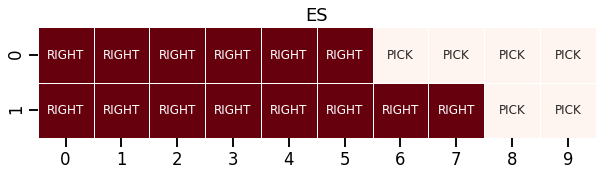

In [14]:
agent.get_policy()
agent.policy
policy_display(env, agent.policy, "ES")

### REINFORCE

In [149]:
env = gym.make('keygrid-v0', grid_length=8)

In [150]:
from reinforce import train

In [151]:
agent = train(env, 300, logs=True)


****************************************************************************************************
TRAINING START


Iteration: 0
state: (0, 0), proba: [0.33 0.33 0.33]
state: (0, 1), proba: [0.34 0.33 0.33]
state: (1, 0), proba: [0.34 0.33 0.33]
state: (1, 1), proba: [0.35 0.32 0.33]
state: (2, 0), proba: [0.34 0.32 0.33]
state: (2, 1), proba: [0.35 0.32 0.33]
state: (3, 0), proba: [0.35 0.32 0.33]
state: (3, 1), proba: [0.35 0.31 0.33]
state: (4, 0), proba: [0.35 0.31 0.33]
state: (4, 1), proba: [0.36 0.31 0.33]
state: (5, 0), proba: [0.36 0.31 0.33]
state: (5, 1), proba: [0.36 0.3  0.34]
state: (6, 0), proba: [0.36 0.3  0.34]
state: (6, 1), proba: [0.36 0.3  0.34]
state: (7, 0), proba: [0.37 0.3  0.34]
state: (7, 1), proba: [0.37 0.29 0.34]
Score: 0
% of visited states: 18.8%

Iteration: 1
Score: 0
% of visited states: 25.0%

Iteration: 2
Score: 0
% of visited states: 43.8%

Iteration: 3
Score: 50
% of visited states: 81.2%

Iteration: 4
Score: 0
% of visited states: 81.2%

Iterat

Score: 50
% of visited states: 100.0%

Iteration: 120
Score: 50
% of visited states: 100.0%

Iteration: 121
Score: 0
% of visited states: 100.0%

Iteration: 122
Score: 50
% of visited states: 100.0%

Iteration: 123
Score: 0
% of visited states: 100.0%

Iteration: 124
Score: 0
% of visited states: 100.0%

Iteration: 125
Score: 0
% of visited states: 100.0%

Iteration: 126
Score: 50
% of visited states: 100.0%

Iteration: 127
Score: 50
% of visited states: 100.0%

Iteration: 128
Score: 50
% of visited states: 100.0%

Iteration: 129
Score: 0
% of visited states: 100.0%

Iteration: 130
Score: 0
% of visited states: 100.0%

Iteration: 131
Score: 50
% of visited states: 100.0%

Iteration: 132
Score: 50
% of visited states: 100.0%

Iteration: 133
Score: 50
% of visited states: 100.0%

Iteration: 134
Score: 50
% of visited states: 100.0%

Iteration: 135
Score: 0
% of visited states: 100.0%

Iteration: 136
Score: 0
% of visited states: 100.0%

Iteration: 137
Score: 0
% of visited states: 100.0%

Score: 50
% of visited states: 100.0%

Iteration: 251
Score: 50
% of visited states: 100.0%

Iteration: 252
Score: 50
% of visited states: 100.0%

Iteration: 253
Score: 50
% of visited states: 100.0%

Iteration: 254
Score: 50
% of visited states: 100.0%

Iteration: 255
Score: 0
% of visited states: 100.0%

Iteration: 256
Score: 50
% of visited states: 100.0%

Iteration: 257
Score: 0
% of visited states: 100.0%

Iteration: 258
Score: 0
% of visited states: 100.0%

Iteration: 259
Score: 0
% of visited states: 100.0%

Iteration: 260
Score: 50
% of visited states: 100.0%

Iteration: 261
Score: 50
% of visited states: 100.0%

Iteration: 262
Score: 50
% of visited states: 100.0%

Iteration: 263
Score: 50
% of visited states: 100.0%

Iteration: 264
Score: 50
% of visited states: 100.0%

Iteration: 265
Score: 0
% of visited states: 100.0%

Iteration: 266
Score: 50
% of visited states: 100.0%

Iteration: 267
Score: 50
% of visited states: 100.0%

Iteration: 268
Score: 0
% of visited states: 100

<Figure size 720x360 with 0 Axes>

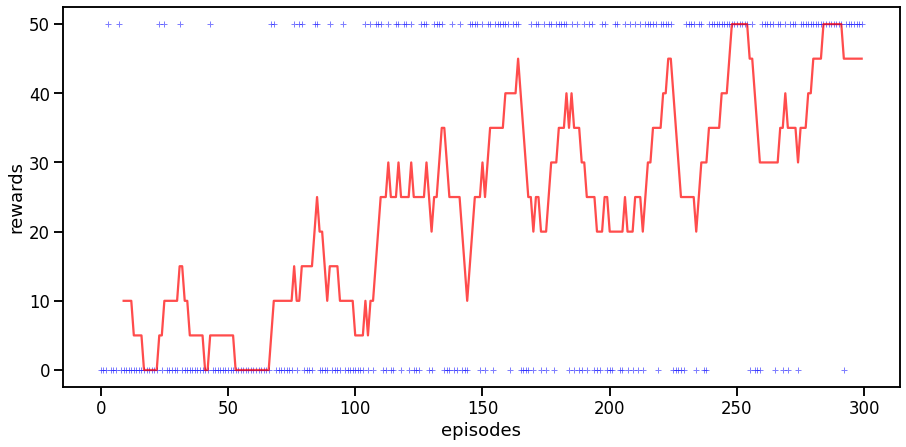

In [155]:
plot_scores(agent.scores)

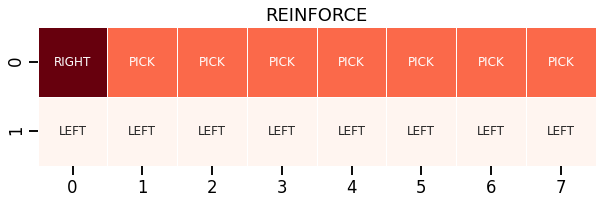

In [156]:
agent.get_policy()
policy_display(env, agent.policy, "REINFORCE")

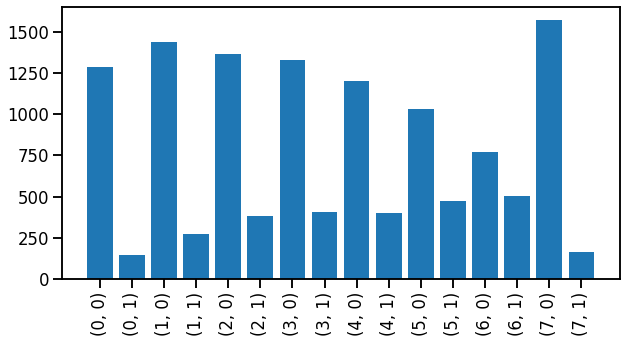

In [157]:
plot_state_freq(agent.state_freq)

### Reinforce count state exploration

In [158]:
from reinforce_count_states import train

In [159]:
agent = train(env, 300, logs=True)


****************************************************************************************************
TRAINING START


Iteration: 0
state: (0, 0), proba: [0.33 0.33 0.33]
state: (0, 1), proba: [0.34 0.31 0.36]
state: (1, 0), proba: [0.34 0.33 0.33]
state: (1, 1), proba: [0.34 0.31 0.36]
state: (2, 0), proba: [0.34 0.33 0.34]
state: (2, 1), proba: [0.34 0.31 0.36]
state: (3, 0), proba: [0.34 0.32 0.34]
state: (3, 1), proba: [0.34 0.31 0.36]
state: (4, 0), proba: [0.34 0.32 0.34]
state: (4, 1), proba: [0.34 0.31 0.35]
state: (5, 0), proba: [0.34 0.32 0.34]
state: (5, 1), proba: [0.34 0.31 0.35]
state: (6, 0), proba: [0.35 0.31 0.34]
state: (6, 1), proba: [0.34 0.31 0.34]
state: (7, 0), proba: [0.35 0.31 0.34]
state: (7, 1), proba: [0.35 0.31 0.34]
Score: 13.587494346898367
% of visited states: 31.2%

Iteration: 1
Score: 12.638214516186315
% of visited states: 62.5%

Iteration: 2
Score: 5.058824434070039
% of visited states: 62.5%

Iteration: 3
Score: 1.42606059318686
% of visited states:

Score: 0.07100606185373685
% of visited states: 100.0%

Iteration: 101
Score: 0.10413350956548618
% of visited states: 100.0%

Iteration: 102
Score: 0.1390557393270299
% of visited states: 100.0%

Iteration: 103
Score: 0.04382914872797255
% of visited states: 100.0%

Iteration: 104
Score: 0.07076917281321844
% of visited states: 100.0%

Iteration: 105
Score: 0.8307276172710545
% of visited states: 100.0%

Iteration: 106
Score: 0.1107007385700897
% of visited states: 100.0%

Iteration: 107
Score: 0.05844706350556056
% of visited states: 100.0%

Iteration: 108
Score: 0.04474120463636718
% of visited states: 100.0%

Iteration: 109
Score: 0.09186657661202131
% of visited states: 100.0%

Iteration: 110
Score: 50.42852496981292
% of visited states: 100.0%

Iteration: 111
Score: 0.04581439793817851
% of visited states: 100.0%

Iteration: 112
Score: 0.058413600027319025
% of visited states: 100.0%

Iteration: 113
Score: 0.06495557683567406
% of visited states: 100.0%

Iteration: 114
Score: 0.0

Score: 0.05987952343185683
% of visited states: 100.0%

Iteration: 201
Score: 50.09814439660181
% of visited states: 100.0%

Iteration: 202
Score: 50.11972845579439
% of visited states: 100.0%

Iteration: 203
Score: 50.10072949237445
% of visited states: 100.0%

Iteration: 204
Score: 0.07000358604968021
% of visited states: 100.0%

Iteration: 205
Score: 50.15886783623004
% of visited states: 100.0%

Iteration: 206
Score: 0.05978390779709007
% of visited states: 100.0%

Iteration: 207
Score: 0.1026963632322622
% of visited states: 100.0%

Iteration: 208
Score: 50.127041641898515
% of visited states: 100.0%

Iteration: 209
Score: 50.09587077388808
% of visited states: 100.0%

Iteration: 210
Score: 50.13822857145572
% of visited states: 100.0%

Iteration: 211
Score: 50.10234085632198
% of visited states: 100.0%

Iteration: 212
Score: 0.07167329220629157
% of visited states: 100.0%

Iteration: 213
Score: 50.10636029372323
% of visited states: 100.0%

Iteration: 214
Score: 50.08263051592967

<Figure size 720x360 with 0 Axes>

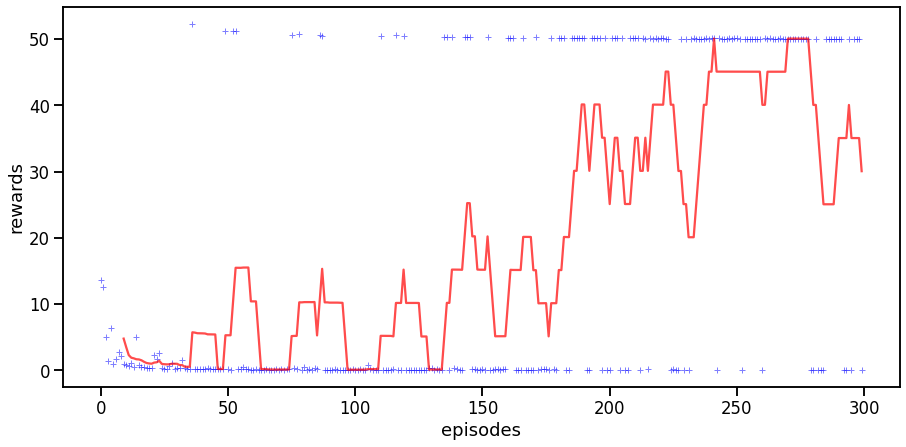

In [160]:
plot_scores(agent.scores)

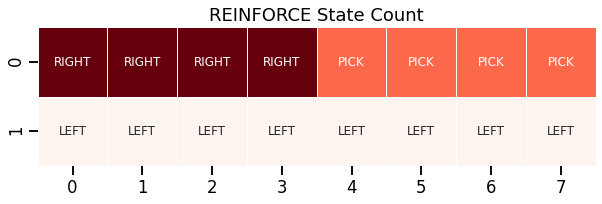

In [161]:
agent.get_policy()
policy_display(env, agent.policy, "REINFORCE State Count")

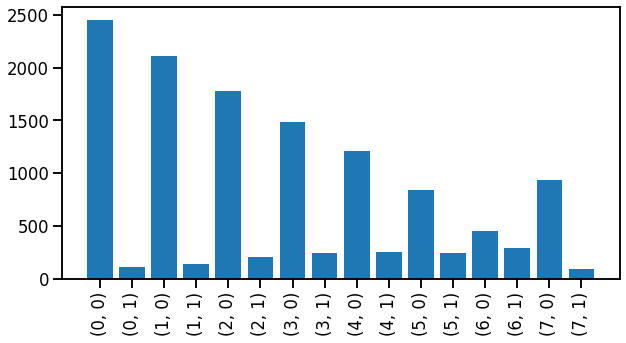

In [162]:
plot_state_freq(agent.state_freq)

### Reinforce count seq exploration

In [163]:
from reinforce_count_seq import train

In [164]:
agent = train(env, 300, logs=False)

<Figure size 720x360 with 0 Axes>

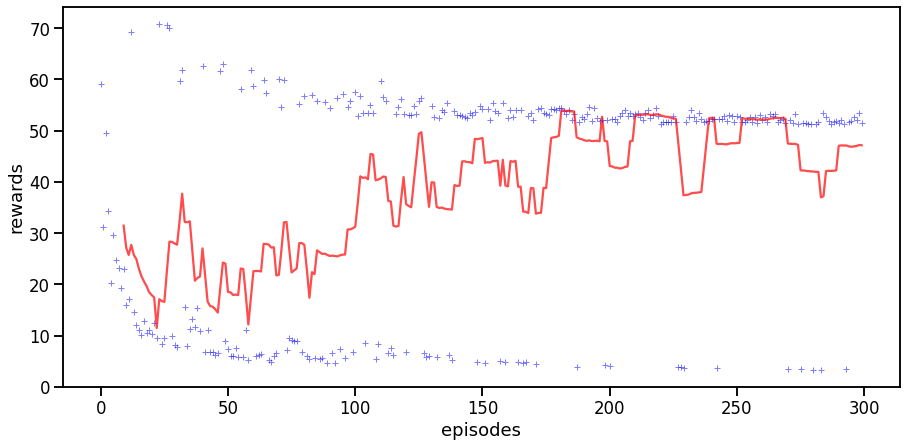

In [165]:
plot_scores(agent.scores)

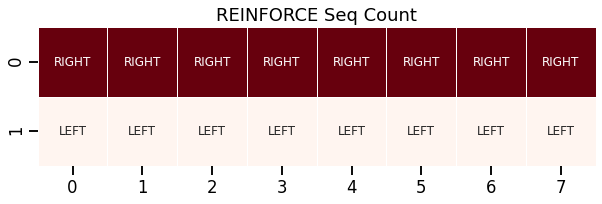

In [166]:
agent.get_policy()
policy_display(env, agent.policy, "REINFORCE Seq Count")

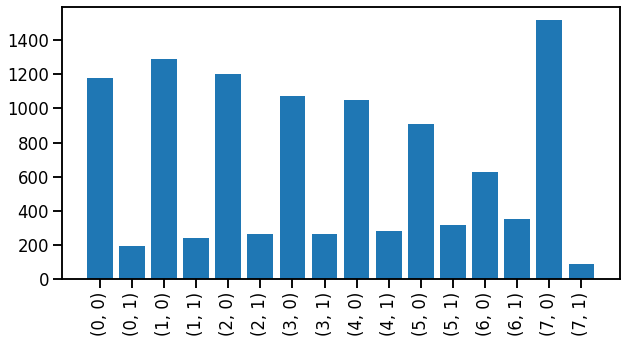

In [171]:
plot_state_freq(agent.state_freq)

In [172]:
agent.get_proba()

state: (0, 0), proba: [0.05 0.16 0.79]
state: (0, 1), proba: [0.99 0.01 0.  ]
state: (1, 0), proba: [0.05 0.16 0.8 ]
state: (1, 1), proba: [0.99 0.   0.  ]
state: (2, 0), proba: [0.04 0.16 0.8 ]
state: (2, 1), proba: [1. 0. 0.]
state: (3, 0), proba: [0.05 0.16 0.79]
state: (3, 1), proba: [1. 0. 0.]
state: (4, 0), proba: [0.07 0.19 0.74]
state: (4, 1), proba: [1. 0. 0.]
state: (5, 0), proba: [0.1  0.23 0.68]
state: (5, 1), proba: [1. 0. 0.]
state: (6, 0), proba: [0.13 0.26 0.61]
state: (6, 1), proba: [1. 0. 0.]
state: (7, 0), proba: [0.18 0.29 0.53]
state: (7, 1), proba: [1. 0. 0.]


In [169]:
for k, v in agent.seq_freq.items():
    if v > 10:
        print(k, v)

(0, 0) 300
(0, 0, 0, 0) 154
(0, 0, 0, 0, 0, 0) 82
(0, 0, 0, 0, 0, 0, 0, 0) 53
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 33
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0) 13
(0, 0, 1, 0) 146
(0, 0, 1, 0, 0, 0) 24
(0, 0, 1, 0, 0, 0, 0, 0) 15
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 20
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 12
(0, 0, 0, 0, 0, 0, 1, 0) 29
(0, 0, 0, 0, 0, 0, 1, 0, 1, 0) 13
(0, 0, 1, 0, 1, 0) 42
(0, 0, 1, 0, 1, 0, 1, 0) 15
(0, 0, 1, 0, 1, 0, 2, 0) 22
(0, 0, 0, 0, 1, 0) 72
(0, 0, 0, 0, 1, 0, 2, 0) 38
(0, 0, 0, 0, 1, 0, 2, 0, 3, 0) 18
(0, 0, 0, 0, 1, 0, 1, 0) 23
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0) 20
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0) 11
(0, 0, 1, 0, 2, 0) 80
(0, 0, 1, 0, 2, 0, 3, 0) 41
(0, 0, 0, 0, 1, 0, 0, 0) 11
(0, 0, 1, 0, 2, 0, 1, 0) 16
(0, 0, 1, 0, 2, 0, 2, 0) 23
(0, 0, 1, 0, 2, 0, 3, 0, 4, 0) 28
(0, 0, 1, 0, 2, 0, 2, 0, 3, 0) 13
(0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0) 13
(0, 0, 1, 0, 1, 0, 2, 0, 2, 0) 11


In [170]:
agent.get_state_freq()

% of visited states: 100.0%


### NS ES

In [ ]:
# from NS_ES import train

In [ ]:
# agent = train(env)

### QD ES

In [ ]:
# npop = 40
# alpha = 0.1
# sigma = 1
# generation = 100

# K = 3
# archive = set()
# while len(archive) != K:
#     archive.add(QD_Agent().get_bc(env))

# agent = QD_Agent()


# print("\n"+"*"*100)
# print("TRAINING START\n")

# for gen in range(generation):
#     new_agents, N = create_pop(agent, npop=npop, sigma=sigma)
#     F = np.zeros(npop)
#     D = []
    
#     for i, n_a in enumerate(new_agents):
#         F[i] = n_a.evaluate(env)
#         D.append(n_a.get_bc(env)) 
    
# #     print(R)
    
#     nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(np.array(list(archive)))
#     D = np.mean(nbrs.kneighbors(np.array(R))[0], axis=1)

#     R = normalize_array(F) + normalize_array(D)
    
#     if np.std(R) == 0:
#         A = np.zeros(npop)
#     else:
#         A = (R - np.mean(R)) / np.std(R)
        
#     for key in agent.weights:
#         agent.weights[key] += alpha/(npop*sigma) * (N[key] @ A)
    
#     archive.add(agent.get_bc(env))
#     print(archive)
# #     print(agent.weights['w1'][0])
    
# #     print("Generation:", gen, "Score:", print(F))

# print("\n"+"*"*100)
# print("TRAINING ENDED\n")

In [23]:
import tensorflow_probability as tfp
import tensorflow as tf

In [24]:
dist = tfp.distributions.Categorical(probs=[0.1, 0.5, 0.4])
n = 1e4
empirical_prob = tf.cast(
    tf.histogram_fixed_width(dist.sample(int(n)), [0, 2], nbins=3), dtype=tf.float32) / n

In [75]:
empirical_prob

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.101 , 0.4931, 0.4059], dtype=float32)>

In [77]:
a = tf.convert_to_tensor(np.array([1, 2, 0]))

In [26]:
dist.probs

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.5, 0.4], dtype=float32)>

In [74]:
res_r = pd.read_csv('data/reinforce_res.csv')
res_r_seq = pd.read_csv('data/reinforce_res_seq.csv')
res_r_st = pd.read_csv('data/reinforce_res_st.csv')


In [78]:
np.sum(np.sum(res_r > 49)>0)

0

In [79]:
np.sum(np.sum(res_r_st > 49)>0)

1

In [80]:
np.sum(np.sum(res_r_seq > 49)>0)

0

In [81]:
res_r_seq

,14,14.1,14.2,14.3,14.4,14.5,14.6,14.7,14.8,14.9
0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
1,24.158427,35.633505,27.705483,28.656983,34.615669,25.041000,23.693310,25.467848,25.006737,29.478517
2,22.693112,18.657874,19.100490,14.298503,25.324236,21.013109,14.012121,17.823378,16.825054,18.101831
3,15.017947,12.569900,12.329730,12.279019,13.873886,11.767409,13.848482,12.300825,11.911354,11.037153
4,9.520565,8.709188,9.128461,8.698023,8.582889,9.046052,7.958709,8.868140,8.741202,7.940865
...,...,...,...,...,...,...,...,...,...,...
396,1.702386,1.174750,1.103350,1.733196,1.607715,1.525501,1.070544,1.495418,1.127626,1.067165
397,1.525925,1.968011,1.646015,1.471506,1.549658,1.380856,1.271534,1.069504,1.123964,1.902122
398,1.512687,1.255510,1.533088,1.361163,1.646833,1.123676,2.215986,1.531544,1.252476,1.764652
399,1.870531,2.292915,1.383264,1.623637,1.408320,1.316792,1.976846,1.893255,1.996091,2.685310
